In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Exercise 1**

Implement a function that returns $n$ samples from a multivariate Gaussian distribution in C++ and wrap it for use in Python using `pybind11`. Use only standard C++ and the `Eigen` library. The function signature in Python  is

```python
def mvnorm(mu, Sigma, n):
    """Returns n random samples from a multivariate Gaussian distribution.
    
    mu is a mean vector
    Sigma is a covariance matrix
    
    Returns an n by p matrix, where p is the dimension of the distribution.
    """
```

In [1]:
%%file ex1.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['eigen']
setup_pybind11(cfg)
%>

#include <random>
#include <functional>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

#include <Eigen/Cholesky>

namespace py = pybind11;
using std::bind;
using Eigen::MatrixXd;
using Eigen::VectorXd;        
using Eigen::LLT;
                
std::default_random_engine re;
std::normal_distribution<double> dist(0, 1);
        
auto rnorm = bind(dist, re);

MatrixXd mvn(VectorXd mu, MatrixXd Sigma, int n) {

    LLT<MatrixXd> S(Sigma); 
    MatrixXd A = S.matrixL();
    int p = mu.size();
    MatrixXd res(n, p);
    
    for (int i=0; i<n; i++) {
        VectorXd z = VectorXd::Zero(p).unaryExpr([](double x) { return rnorm(); });
        res.row(i) = mu + A * z;
    }
    
    return res;
}

PYBIND11_PLUGIN(ex1) {
    pybind11::module m("ex1", "auto-compiled c++ extension");
    m.def("mvn", &mvn);
    return m.ptr();
}

Overwriting ex1.cpp


In [2]:
import cppimport
import numpy as np

code = cppimport.imp("ex1")

mu = np.array([10, 5])
Sigma = np.array([
    [1, 0.6],
    [0.6, 1]
])
n = 5
res = code.mvn(mu, Sigma, n)
print(res)

[[ 8.7602641   3.93018103]
 [11.61200943  6.28702219]
 [11.38280167  5.87153599]
 [ 9.09585349  5.95403474]
 [ 8.33957126  3.45327834]]


**Exercise 2**

- Consider a sequence of $n$ Bernoulli trials with success probability $p$ per trial. A string of consecutive successes is known as a success *run*. Write a function that returns the counts for runs of length $k$ for each $k$ observed in a dictionary.

For example: if the trials were [0, 1, 0, 1, 1, 0, 0, 0, 0, 1], the function should return 
```
{1: 2, 2: 1})
```

- What is the probability of observing at least one run of length 5 or more when $n=100$ and $p=0.5$?. Estimate this from 100,000 simulated experiments. Is this more, less or equally likely than finding runs of length 7 or more when $p=0.7$?

In [4]:
from collections import Counter

def count_runs(xs):
    """Count number of success runs of length k."""
    ys = []
    count = 0
    for x in xs:
        if x == 1:
            count += 1        
        else:
            if count: 
                ys.append(count)
                count = 0
    if count: 
        ys.append(count)
    return Counter(ys)

In [5]:
count_runs([0, 1, 0, 1, 1, 0, 0, 0, 0, 1])

Counter({1: 2, 2: 1})

In [6]:
def count_runs_alt(x):
    """Returns the counts for runs of length  k for each observed in x.
    
    This works but is slower.
    """
    return Counter(len(s) for s in ''.join(map(str, x)).split('0') if s)

In [7]:
count_runs_alt([0, 1, 0, 1, 1, 0, 0, 0, 0, 1])

Counter({1: 2, 2: 1})

In [8]:
%timeit count_runs([0, 1, 0, 1, 1, 0, 0, 0, 0, 1])

The slowest run took 4.84 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 6.08 µs per loop


In [9]:
%timeit count_runs_alt([0, 1, 0, 1, 1, 0, 0, 0, 0, 1])

100000 loops, best of 3: 8.97 µs per loop


In [10]:
def run_prob(expts, n, k, p):
    xxs = np.random.choice([0,1], (expts, n), p=(1-p, p))
    return sum(max(d.keys()) >= k for d in map(count_runs, xxs))/expts

In [11]:
run_prob(expts=100000, n=100, k=5, p=0.5)

0.8103

In [12]:
run_prob(expts=100000, n=100, k=7, p=0.7)

0.94929

**Exercise 3**.

- Consider an unbiased random walk of length $n$ as simulated with a sequence of -1 or +1 values. If we start from 0, plot the distribution of *last* return times for 100,000 simulations with $n = 100$. The last return time is the last time the cumulative sum of the random walk is zero - this may be the starting point if the walk never returns to zero in 100 steps. 

- Do a maximum likeliood fit of a beta distribution to the set of last return times using the `beta.fit()` function from `scipy.stats`. Set the lower bound (loc) = 0 and the upper bound (scale) = 100 for plotting. Superimpose the fitted beta PDF on the normalized histogram of last reutrn times.

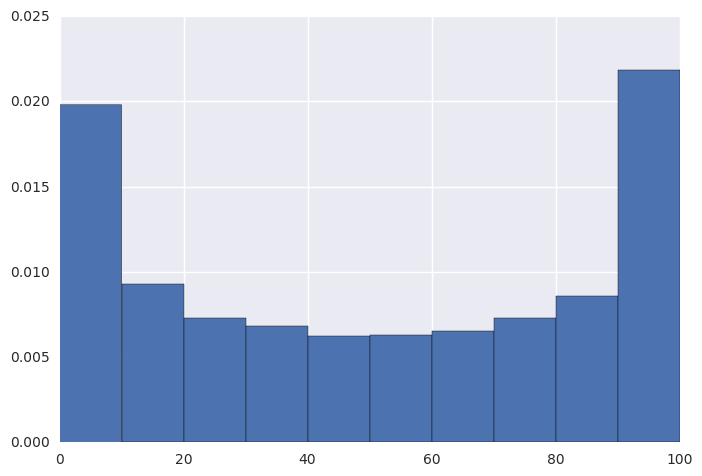

In [13]:
n = 100
k = 100000

returns = np.zeros(k).astype('int')
for i in range(k):
    x = np.random.choice([-1,1], n)
    y = np.r_[0, np.cumsum(x)]
    returns[i] = np.nonzero(y == 0)[0][-1]
plt.hist(returns, normed=True)
pass

In [14]:
from scipy.stats import beta

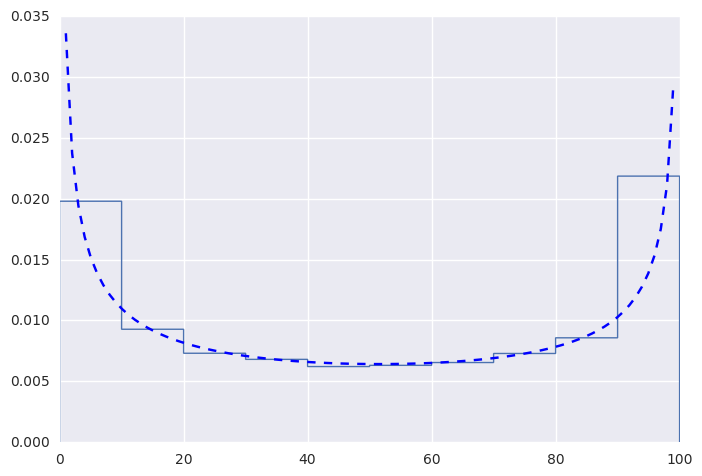

In [15]:
a, b, loc, scale = beta.fit(returns)
x = np.linspace(0, 100, 100)
plt.plot(x, beta(a=a, b=b, loc=0, scale=100).pdf(x), linestyle='dashed', color='blue')
plt.hist(returns, histtype='step', normed=True, linewidth=1)
pass

**Exercise 4**

The Cauchy distribution is given by 
$$
f(x) = \frac{1}{\pi (1 + x^2)}, \ \ -\infty \lt x \lt \infty 
$$

- Integrate the tail probability $P(X > 2)$ using Monte Carlo
    1. Sampling from the Cauchy distribution directly
    2. Sampling from the uniform distribution using an appropriate change of variables
- Plot the 95% CI for the Monte Carlo estimates for n = 1 to 1000
    1. For sampling from the Cauchy distribution using mulitple Monte Carlo sequences
    2. For sampling from the uniform distribution using bootstrap samples of a single Monte Carlo sequence




In [16]:
from scipy import stats

In [17]:
# Direct
n = 1000
sum(stats.cauchy().rvs(n) > 2)/n

0.156

In [18]:
# After change of variables
x = stats.uniform().rvs(n)
np.mean(2/(np.pi*(x**2+4)))

0.14766263754289377

In [19]:
# Check (not required)
1 -  stats.cauchy.cdf(2)

0.14758361765043326

#### Sampling from the Cauchy distribution using mulitple Monte Carlo sequences

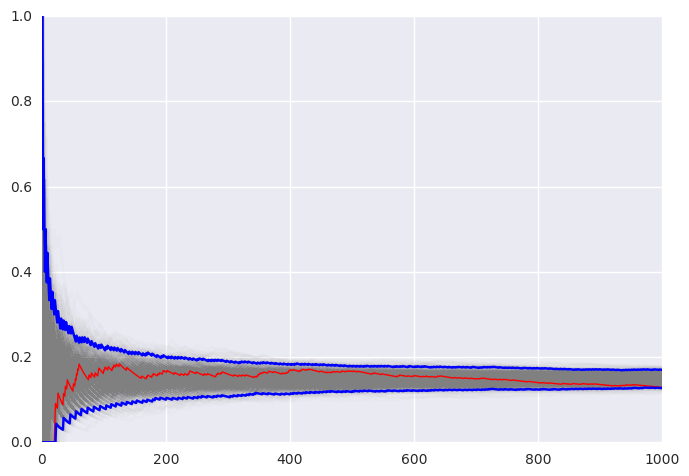

In [20]:
n=1000
reps = 1000

samples = stats.cauchy().rvs((n, reps))

# repeat multiple Monte Carlo sequences
ys = np.zeros((n, reps))
for k in range(1, n+1):
    ys[k-1] = np.sum(samples[:k, :] > 2, axis=0)/k
upper, lower = np.percentile(ys, [2.5, 97.5], axis=1)

plt.plot(np.arange(1, n+1)[:, None], ys, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), ys[:, 0], c='red', linewidth=1) # one path
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

#### Sampling from the uniform distribution using bootstrap samples of a single Monte Carlo sequence

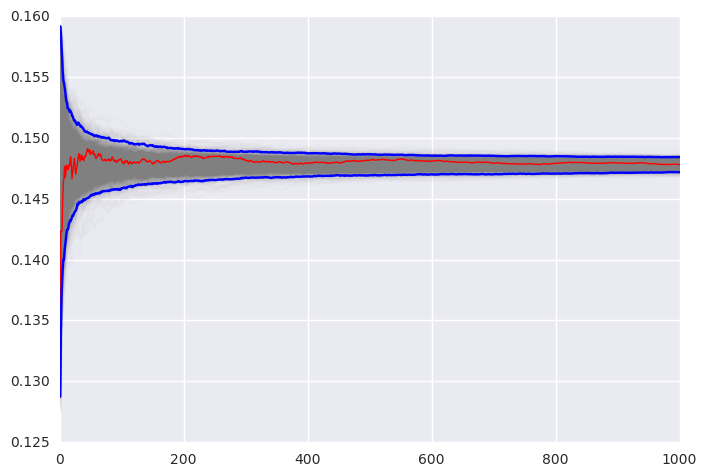

In [21]:
n=1000
reps = 1000

samples = stats.uniform().rvs(n)
samples = 2/(np.pi*(samples**2+4))

# generate bootsrap samples
xb = np.random.choice(samples, (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass